# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
from time import perf_counter as pc
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import split_agents, plot_solve
import decentralized as dec
import pocketknives

π = np.pi
g = 9.80665

In [2]:
%matplotlib ipympl
plt.rcParams['axes.grid'] = False

In [3]:
plt.rc('font',size=12)
plt.rc('font',family='palatino')
plt.rc('axes',labelsize=14)

In [4]:
import seaborn as sns 
sns.set()

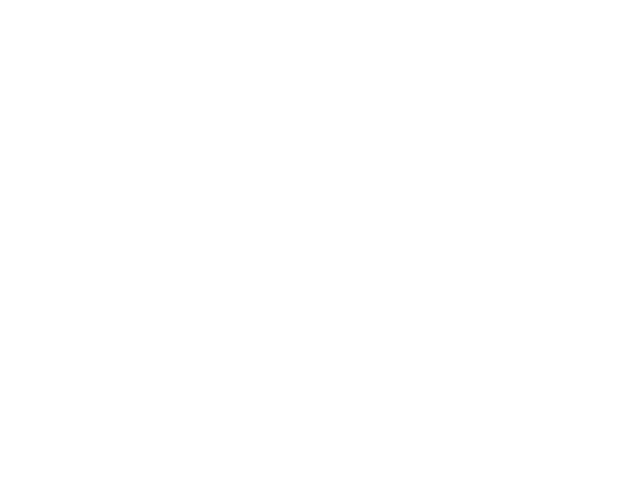

In [4]:
# fig = plt.figure(figsize=(3.7, 3.7))
fig = plt.figure()

## single-agent problem

Show equations of motion, which have the form

$$\dot{x} = f(x, u, p)$$

for states

$$
x = \begin{bmatrix} o_x & o_y & o_z & \psi & \theta & \phi & v_x & v_y & v_z & w_x & w_y & w_z \end{bmatrix},
$$

inputs
$$
u = \begin{bmatrix} \tau_x & \tau_y & \tau_z & f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m & J_x & J_y & J_z & g \end{bmatrix}.
$$

In [ ]:
# Single-agent problem for a 12D quadcopter (w/ analytical diff.)
dt = 0.1
N = 40
n_d = 3

x = np.array([2, 2, 0.5 , 0.05, 0, 0, 0.0, 0.0, 0, 0, 0, 0], dtype=float)
xf = np.zeros((12, 1), dtype=float).T

dynamics = dec.QuadcopterDynamics12D(dt)

# Q = np.diag([1., 1., 1., 0, 0, 0, 0, 0, 0, 0, 0, 0])
Q = np.diag([1., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Qf = 100 * np.eye(Q.shape[0])
R = np.eye(4)
cost = dec.ReferenceCost(xf, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

# with warnings.catch_warnings():
    # warnings.filterwarnings("error")
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, xf, n_d=n_d)
plt.draw()

In [ ]:
# Single-agent problem for a 6D quadcopter (w/ analytical diff.)
dt = 0.1
N = 40
n_d = 3

x = np.array([2, 2, 0.5 , 0, 0, 0], dtype=float)
xf = np.zeros((6, 1), dtype=float).T

dynamics = dec.QuadcopterDynamics6D(dt)

# Q = np.diag([1., 1., 1., 0, 0, 0, 0, 0, 0, 0, 0, 0])
Q = np.diag([1., 1., 1., 1., 1., 1.])
Qf = 100 * np.eye(Q.shape[0])
R = np.diag([0, 1, 1])
cost = dec.ReferenceCost(xf, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

# with warnings.catch_warnings():
    # warnings.filterwarnings("error")
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, xf, n_d=n_d)
plt.draw()

## Human Agent Alone

In [6]:
dt = 0.1
N = 40
n_d = 3

x = np.array([2, 2, 1.75 , 0, 0, 0], dtype=float)
xf = np.zeros((6, 1), dtype=float).T
xf[:,2] = 1.75
dynamics = dec.HumanDynamics6D(dt)


Q = np.diag([1., 1., 1., 1., 1., 1.])
Qf = 100 * np.eye(Q.shape[0])
R = np.eye(3)
cost = dec.ReferenceCost(xf, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

X, U, J = ilqr.solve(x)

0/50	J: 1120
1/50	J: 602.081	μ: 0.5	Δ: 0.5
2/50	J: 167.359	μ: 0.125	Δ: 0.25
3/50	J: 150.801	μ: 0.015625	Δ: 0.125
4/50	J: 136.326	μ: 0.000976562	Δ: 0.0625
5/50	J: 128.486	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 127.543	μ: 0	Δ: 0.015625
7/50	J: 127.059	μ: 0	Δ: 0.0078125


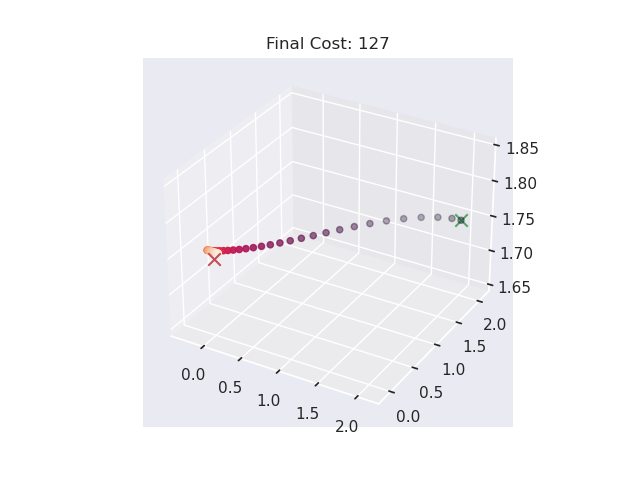

In [8]:
plt.clf()
plt.figure()
plot_solve(X, J, xf, n_d=n_d)
plt.draw()

## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [5]:
def paper_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = np.array([[0.5, 1.5, 0, 0.1,
                    2.5, 1.5, 0, π,
                    1.5, 1.3, 0, π/2]], 
                     dtype=float).T
    xf = np.array([[2.5, 1.5, 0, 0, 
                        0.5, 1.5, 0, π, 
                        1.5, 2.2, 0, π/2]]).T
    return x0, xf

def dec_test_setup():
    x0, xf = paper_setup()
    x0_other = np.array([[5, 5, 0, 0,
                          6, 6, 0, π/4]]).T
    xf_other = np.array([[6, 4, 0, -π/2,
                              4, 6, 0, π/4]]).T
    
    x0 = np.concatenate([x0, x0_other]) 
    xf = np.concatenate([xf, xf_other])    
    
    return x0, xf

def paper_setup_3_quads():
    x0 = np.array([[0.5, 1.5, 1, 0, 0, 0,
                    2.5, 1.5, 1, 0, 0, 0,
                    1.5, 1.3, 1, 0, 0, 0]], 
                     dtype=float).T
    xf = np.array([[2.5, 1.5, 1, 0, 0, 0, 
                    0.5, 1.5, 1, 0, 0, 0, 
                    1.5, 2.2, 1, 0, 0, 0]]).T
    x0[dec.pos_mask([6]*3, 3)] += 0.01*np.random.randn(9, 1)
    xf[dec.pos_mask([6]*3, 3)] += 0.01*np.random.randn(9, 1)
    return x0, xf

In [10]:
def paper_example_unicycles():
    """5 agents with crossing, N = 60, R = 2I"""
    x0 = np.array([[-3.894,  1.453,  0.   ,  0.   ,  0.873,  4.82 ,  0.   ,  0.   ,
        -3.372, -3.415,  0.   ,  0.   ,  3.502,  4.681,  0.   ,  0.   ,
         4.592,  0.605,  0.   ,  0.   ]]).T
    xf = np.array([[ 4.877,  2.181,  0.   ,  0.   ,  1.928, -0.136,  0.   ,  0.   ,
        -1.879,  3.688,  0.   ,  0.   , -2.026, -0.522,  0.   ,  0.   ,
         4.043, -3.767,  0.   ,  0.   ]]).T
    return x0, xf

In [ ]:
def paper_example_quads():
    """10 quadcopters, N = 60"""
    x0 = np.array([[ 5.915, -7.175,  1.903,  0.   ,  0.   ,  0.   ,  1.838,  2.391,
         5.71 ,  0.   ,  0.   ,  0.   ,  3.706,  3.317, -8.283,  0.   ,
         0.   ,  0.   ,  6.694,  7.111,  6.155,  0.   ,  0.   ,  0.   ,
        -9.541,  0.501,  2.488,  0.   ,  0.   ,  0.   , -4.286, -7.567,
        -7.29 ,  0.   ,  0.   ,  0.   ,  3.574, -4.309, -1.497,  0.   ,
         0.   ,  0.   ,  0.417, -2.895,  0.594,  0.   ,  0.   ,  0.   ,
        -6.272, -6.414, -1.265,  0.   ,  0.   ,  0.   ,  7.108, -9.521,
        -5.234,  0.   ,  0.   ,  0.   ]]).T
    xf = np.array([[ 0.586,  6.324,  8.746,  0.   ,  0.   ,  0.   , -5.768, -5.674,
         9.156,  0.   ,  0.   ,  0.   ,  1.384,  6.137,  3.046,  0.   ,
         0.   ,  0.   , -9.182,  1.458, -5.108,  0.   ,  0.   ,  0.   ,
        -4.171, -3.339, -6.949,  0.   ,  0.   ,  0.   , -9.142, -1.331,
         7.007,  0.   ,  0.   ,  0.   , -2.239, -7.678,  3.992,  0.   ,
         0.   ,  0.   ,  0.704, -4.572,  9.133,  0.   ,  0.   ,  0.   ,
         4.2  , -8.159,  4.172,  0.   ,  0.   ,  0.   ,  7.384, -1.938,
        -5.644,  0.   ,  0.   ,  0.   ]]).T

    return x0, xf

## quadcopters w/ human

In [22]:
n_states = 6
n_controls = 3
n_agents = 3

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents
n_dims = [3, 2, 2]
# second and third agent are human agents

dt = 0.1
N = 20
radius = 1.0

x0 = np.array([
    [-0.2, 2, 0, -π/2, 0, 0], 
    [-2, 1.6, 1.75, -0.01, -0.01, 0.0],
    [0.5, 1.0, 1.73, 0.01, -0.01, 0.0]
]).flatten()
xf = np.array([
    [0.4, -2, 0, -π/2, 0, 0], 
    [1, -1.9, 1.75, 0, 0, 0],
    [1, 1.9, 1.73, 0, 0, 0]
]).flatten() 

Q = np.diag([1, 1, 1, 1, 1, 1])
R = np.diag([1, 1, 1])
Qf = 1e3 * np.eye(n_states)

models = [dec.HumanDynamics6D, dec.QuadcopterDynamics6D, dec.QuadcopterDynamics6D]
ids = [100 + i for i in range(n_agents)]
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_, model in zip(ids, models)])

goal_costs = [
    dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_)
    for xf_i, id_, x_dim, u_dim in zip(
        dec.split_agents_gen(xf, x_dims), ids, x_dims, u_dims
    )
]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
game_cost = dec.GameCost(goal_costs, prox_cost)

problem = dec.ilqrProblem(dynamics, game_cost)
solver = dec.ilqrSolver(problem, N)

In [26]:
U0 = np.zeros((N, n_agents*n_controls))
X, U, J, _ = dec.solve_centralized(solver, x0, U0, ids, True)

0/50	J: 1.58562e+06
1/50	J: 82571.2	μ: 0.5	Δ: 0.5
2/50	J: 59550.6	μ: 0.125	Δ: 0.25
3/50	J: 36029.9	μ: 0.015625	Δ: 0.125
4/50	J: 35478.9	μ: 0.000976562	Δ: 0.0625
5/50	J: 30606.6	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 12214.1	μ: 0	Δ: 0.015625
7/50	J: 11778.4	μ: 0	Δ: 0.0078125
8/50	J: 9423.88	μ: 0	Δ: 0.00390625
9/50	J: 9202.37	μ: 0	Δ: 0.00195312
10/50	J: 9159.02	μ: 0	Δ: 0.000976562
11/50	J: 8659.29	μ: 0	Δ: 0.000488281
12/50	J: 8115.56	μ: 0	Δ: 0.000244141
13/50	J: 6312.67	μ: 0	Δ: 0.00012207
Failed line search, giving up.


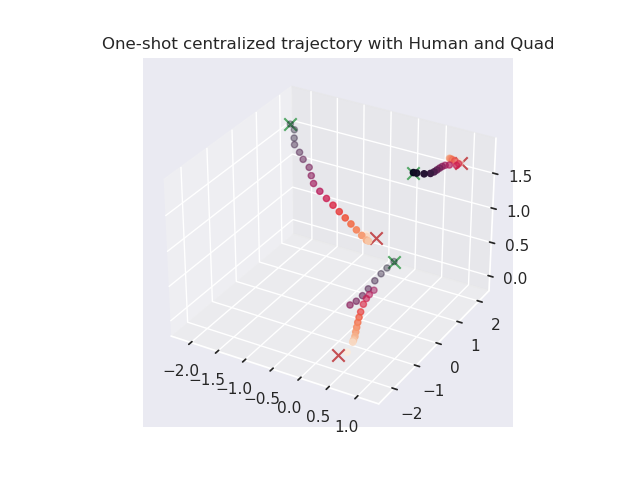

In [27]:
plt.clf()
plt.figure()
plot_solve(X, J, xf, x_dims, n_d=3)
plt.title('One-shot centralized trajectory with Human and Quad')
plt.draw()

In [28]:
U0 = np.zeros((N, n_agents*n_controls))
X0 = np.tile(x0, (N+1, 1))
X_dec, U_dec, J_dec, _ = dec.solve_decentralized(problem, X0, U0, radius, verbose=True)

Interaction Graph: {100: [100, 101, 102], 101: [100, 101], 102: [100, 102]}
Problem 100: [100, 101, 102]
Took 0.3650625000009313 seconds

Problem 101: [100, 101]
Took 0.30673539999406785 seconds

Problem 102: [100, 102]
Took 0.07512410002527758 seconds



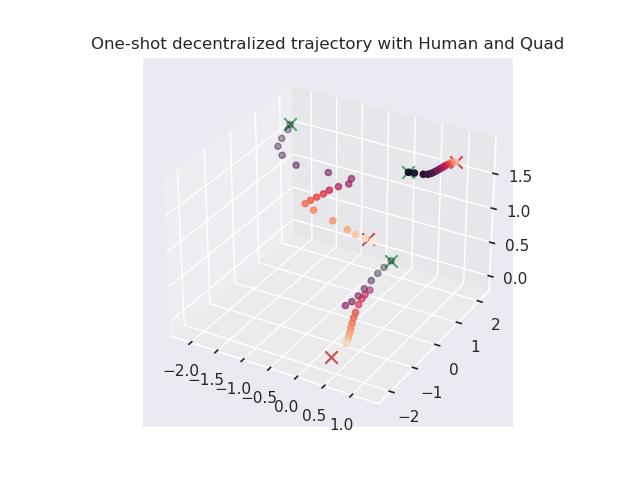

In [29]:
plt.clf()
plt.figure()
plot_solve(X_dec, J_dec, xf, x_dims, n_d=3)
plt.title('One-shot decentralized trajectory with Human and Quad')
plt.draw()

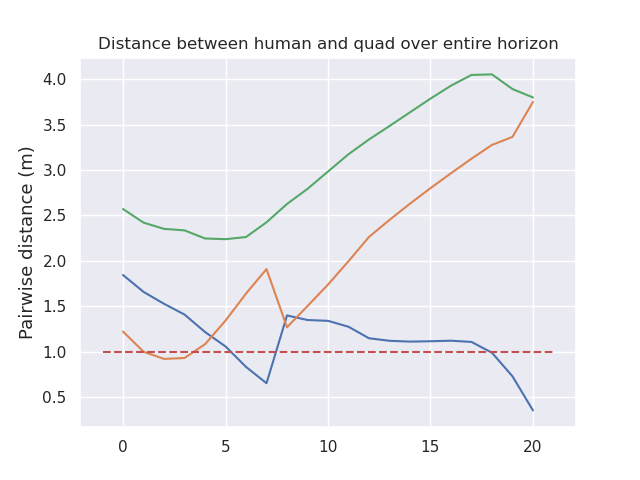

In [30]:
plt.clf()
plt.figure()
plt.plot(dec.compute_pairwise_distance(X, x_dims, n_dims[1]))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.title('Distance between human and quad over entire horizon')
plt.ylabel('Pairwise distance (m)',fontsize=13)
plt.draw()

In [31]:
%%time
n_d = 3
step_size = 3
N = 15

# Start in hover condition.
# U0 = np.zeros((N, n_agents*n_controls))
U0 = np.c_[
    np.zeros((N, 3)),
    np.tile([g, 0, 0], (N, 2))
]

radius = 0.5
X_rhc, U_rhc, J_rhc = dec.solve_rhc(
    problem, x0, N, radius,
    centralized=False,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=0.1,
    verbose=True,
    t_kill=step_size*dt,
    t_diverge=None
)

t: 0
t: 0.3
t: 0.6
t: 0.9
t: 1.2
t: 1.5
t: 1.8
t: 2.1
t: 2.4
t: 2.7
t: 3
t: 3.3
t: 3.6
t: 3.9
t: 4.2
t: 4.5
t: 4.8
t: 5.1
t: 5.4
t: 5.7
t: 6
t: 6.3
t: 6.6
t: 6.9
t: 7.2
t: 7.5
t: 7.8
t: 8.1
t: 8.4
t: 8.7
t: 9
t: 9.3
t: 9.6
t: 9.9
t: 10.2
t: 10.5
t: 10.8
t: 11.1
t: 11.4
t: 11.7
t: 12
t: 12.3
t: 12.6
t: 12.9
t: 13.2
t: 13.5
t: 13.8
t: 14.1
t: 14.4
t: 14.7
t: 15
t: 15.3
t: 15.6
t: 15.9
t: 16.2
t: 16.5
t: 16.8
t: 17.1
t: 17.4
t: 17.7
t: 18
t: 18.3
t: 18.6
t: 18.9
t: 19.2
t: 19.5
t: 19.8
t: 20.1
t: 20.4
t: 20.7
t: 21
t: 21.3
t: 21.6
t: 21.9
t: 22.2
t: 22.5
t: 22.8
t: 23.1
t: 23.4
t: 23.7
t: 24
t: 24.3
t: 24.6
t: 24.9
t: 25.2
t: 25.5
t: 25.8
t: 26.1
t: 26.4
t: 26.7
t: 27
t: 27.3
t: 27.6
t: 27.9
t: 28.2
t: 28.5
t: 28.8
t: 29.1
t: 29.4
t: 29.7
t: 30
t: 30.3
t: 30.6
t: 30.9
t: 31.2
t: 31.5
t: 31.8
t: 32.1
t: 32.4
t: 32.7
t: 33
t: 33.3
t: 33.6
t: 33.9
t: 34.2
t: 34.5
t: 34.8
t: 35.1
t: 35.4
t: 35.7
t: 36
t: 36.3


KeyboardInterrupt: 

In [ ]:
plt.clf()
plt.figure()
plot_solve(X_rhc, J_rhc, xf, x_dims, n_d=3)
plt.title('RHC with human and quad')
plt.draw()

In [ ]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X, x_dims, n_dims[1]))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.title('Distance between human and quad over entire horizon')
plt.ylabel('Pairwise distance (m)',fontsize=13)
plt.draw()

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

### uniform agents

In [6]:
def paper_setup_3_quads():
    x0 = np.array([[0.5, 1.5, 1, 0.5, 0.0, 0,
                    2.5, 1.5, 1, -0.5, 0.0, 0,
                    1.5, 1.3, 1, 0, 0.2, 0]], 
                     dtype=float).T
    xf = np.array([[2.5, 1.5, 1, 0, 0, 0, 
                    0.5, 1.5, 1, 0, 0, 0, 
                    1.5, 2.2, 1, 0, 0, 0]]).T
    x0[dec.pos_mask([6]*3, 3)] += 0.1*np.random.randn(9, 1)
    xf[dec.pos_mask([6]*3, 3)] += 0.1*np.random.randn(9, 1)
    return x0, xf

In [7]:
def paper_setup_5_quads():
    x0 = np.array([[0.5, 1.5, 1, 0.1, 0.0, 0,
                    2.5, 1.5, 1, -0.1, 0.0, 0,
                    1.5, 1.3, 1, 0, 0.1, 0,
                    0.5, 1.0, 1, 0.1, 0, 0,
                    1.2,-0.5, 1, 0, 0, 0]], 
                     dtype=float).T
    xf = np.array([[2.5, 1.5, 1, 0, 0, 0, 
                    0.5, 1.5, 1, 0, 0, 0, 
                    1.5, 2.2, 1, 0, 0, 0,
                    -0.5,-0.6, 1, 0, 0, 0,
                    0.7, 1.0, 1, 0, 0, 0]]).T
    x0[dec.pos_mask([6]*5, 3)] += 0.1*np.random.randn(15, 1)
    xf[dec.pos_mask([6]*5, 3)] += 0.1*np.random.randn(15, 1)
    return x0, xf

In [60]:
def paper_setup_7_quads():
    x0 = np.array([[0.5, 1.5, 1, 0.1, 0.0, 0,
                    2.5, 1.5, 1, -0.1, 0.0, 0,
                    1.5, 1.3, 1, 0, 0.1, 0,
                    0.5, 1.0, 1, 0.1, 0, 0,
                    1.2,-0.5, 1, 0, 0, 0,
                    1.7, 1.4, 1, 0, 0, 0,
                    -1.5, 1.1, 1, 0.1, 0, 0]], 
                     dtype=float).T
    xf = np.array([[2.5, 1.5, 1, 0, 0, 0, 
                    0.5, 1.5, 1, 0, 0, 0, 
                    1.5, 2.2, 1, 0, 0, 0,
                    -0.5,-0.6, 1, 0, 0, 0,
                    0.7, 1.0, 1, 0, 0, 0,
                    2.0, 2.1, 1, 0, 0, 0,
                    -0.6, 0.6, 1, 0, 0, 0]]).T
    x0[dec.pos_mask([6]*7, 3)] += 0.1*np.random.randn(21, 1)
    xf[dec.pos_mask([6]*7, 3)] += 0.1*np.random.randn(21, 1)
    return x0, xf

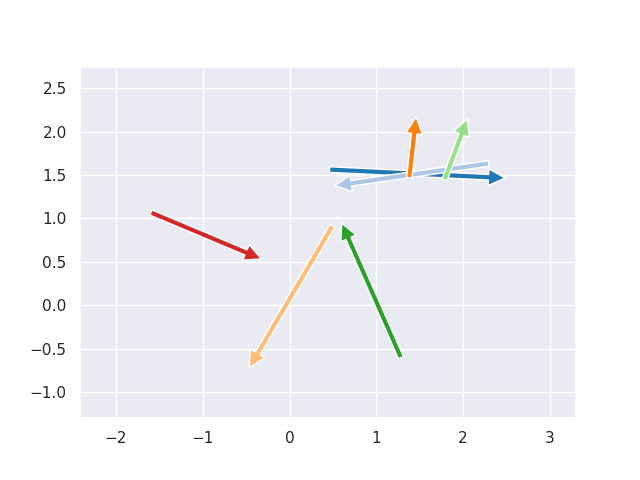

In [92]:
n_states = 6
n_controls = 3
n_agents = 7
x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents
n_dims = [3] * n_agents

# ENERGY = 20.0
n_d = n_dims[0]

# x0, xf = paper_setup()
# x0, xf = car_setup()
# x0, xf = bike_setup()
# x0, xf = double_int_setup()
# x0, xf = dec_test_setup()
# x0, xf = dec.random_setup(
#     n_agents, n_states, 
#     is_rotation=False, 
#     rel_dist=2.0, 
#     var=n_agents/2, 
#     n_d=2, 
#     random=True
# )


# x0, xf = paper_example_unicycles()
# x0, xf = paper_setup_3_quads()
x0, xf = paper_setup_7_quads()

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents

# x0 = dec.normalize_energy(x0, x_dims, ENERGY)
# xf = dec.normalize_energy(xf, x_dims, ENERGY)
# x0 = dec.perturb_state(x0, x_dims)

plt.clf()
plt.figure()
plt.gca().set_aspect('equal')
X = np.dstack([
    x0.reshape(n_agents, n_states), 
    xf.reshape(n_agents, n_states)
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[i]))
pocketknives.set_bounds(X.reshape(-1, n_states), zoom=0.2)
plt.draw()

In [93]:
dt = 0.05
N = 30

tol = 1e-6
ids = [100 + i for i in range(n_agents)]

# model = dec.DoubleIntDynamics4D
# model = dec.UnicycleDynamics4D
# model = dec.BikeDynamics5D
model = dec.QuadcopterDynamics6D
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_ in ids])

# Q = np.eye(4)
# R = np.eye(2)
Q = np.diag([1, 1, 1, 5, 5, 5])
R = np.diag([0, 1, 1])
Qf = 1e3 * np.eye(n_states)
radius = 0.7

goal_costs = [
    dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_)
    for xf_i, id_, x_dim, u_dim in zip(
        dec.split_agents_gen(xf, x_dims), ids, x_dims, u_dims
    )
]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
goal_costs = [dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_) 
              for xf_i, id_ in zip(split_agents(xf.T, x_dims), ids)]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
game_cost = dec.GameCost(goal_costs, prox_cost)

problem = dec.ilqrProblem(dynamics, game_cost)
solver = dec.ilqrSolver(problem, N)

# U0 = None

In [94]:
# %%time
# U0 = np.tile([1.5*g, 0, 0.0], (N, n_agents))
# U0[:, ~dec.pos_mask([3]*3, 1)] = 1e-3*np.random.randn(N, n_agents*(n_controls-1))
# X, U, J = solver.solve(x0, U0, tol=tol, t_kill=None)

In [71]:
# # fname = "10-quads"
# # fname = "5-unicycles"
# fname = "_"

/tmp/ipykernel_10478/2913779742.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


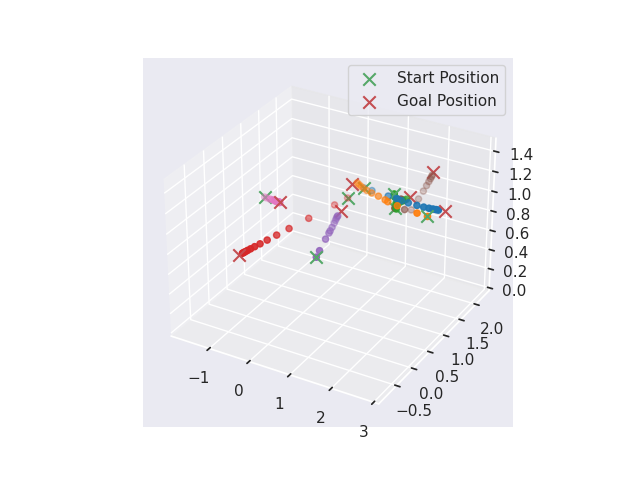

In [72]:
plt.clf()
plt.figure()
plot_solve(X, J, xf.T, x_dims, True, n_d)

ax = plt.gca()
# ax.set_title("5 Unicycle Agents")
# ax.set_xlabel("$x$")
# ax.set_ylabel("$y$")
# ax.set_zlabel("$z$")
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
# pocketknives.ticks_off()
ax.set_title('')
# ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"], loc=(-0.2, 0.75))
# ax.yaxis.set_major_locator(plt.MultipleLocator(3))
# plt.savefig(f"/home/iconlab/Downloads/{fname}.png")
# plt.gcf().set_facecolor("#EAEAF2")
plt.gca().set_zlim(0, 1.5)
plt.draw()


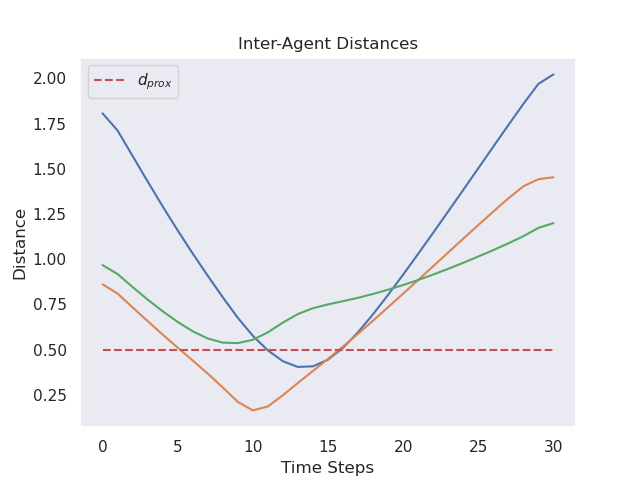

In [ ]:
plt.clf()
plt.figure()
plt.plot(dec.compute_pairwise_distance(X, x_dims, n_d))
plt.hlines(radius, 0, N, 'r', ls='--', label="$d_{prox}$")
plt.title("Inter-Agent Distances")
plt.xlabel("Time Steps")
plt.ylabel("Distance")
plt.legend()
plt.grid(False)
plt.draw()
# plt.savefig(f"/home/iconlab/Downloads/{fname}-distances.png")

In [ ]:
costs = []
for xi, ui in zip(X, U):
    costs.append(game_cost(xi, ui).item())
plt.clf()
plt.plot(costs)
plt.draw()

## decentralized multi-agent

In [44]:
graph = dec.define_inter_graph_threshold(X, 4*radius, x_dims, ids)
graph

{100: [100, 101, 102], 101: [100, 101, 102], 102: [100, 101, 102]}

In [45]:
nx.draw_networkx?

Object `nx.draw_networkx` not found.


Text(0.5, 1.0, 'One-Shot Interaction Graph')

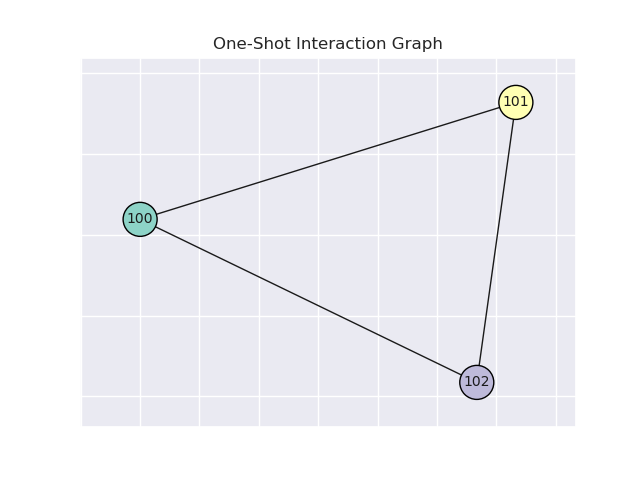

In [46]:
plt.clf()
dec.plot_interaction_graph(graph)
plt.title("One-Shot Interaction Graph")

In [ ]:
plt.grid(False)
plt.savefig("/home/iconlab/Downloads/graph.png")

In [90]:
# %%time
X0 = np.tile(x0.T, (N,1))
U0 = np.zeros((N, n_controls*n_agents))
X_dec1, U_dec1, J_dec, _ = dec.solve_decentralized(problem, X0, U0, radius)

Interaction Graph: {100: [100, 102], 101: [101], 102: [100, 102]}
Problem 100: [100, 102]
Took 0.32677260000491515 seconds

Problem 101: [101]
Took 0.04581689997576177 seconds

Problem 102: [100, 102]
Took 0.33093650004593655 seconds



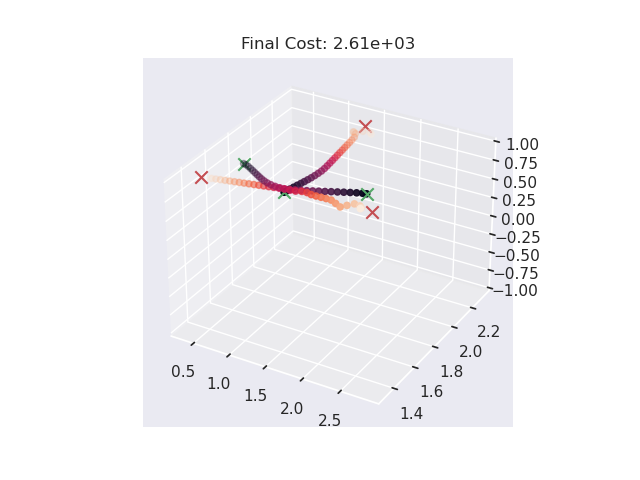

In [50]:
plt.clf()
plt.figure()
plot_solve(X_dec1, J_dec, xf, x_dims, n_d=3)
plt.gca().set_zlim(-1, 1)
plt.draw()

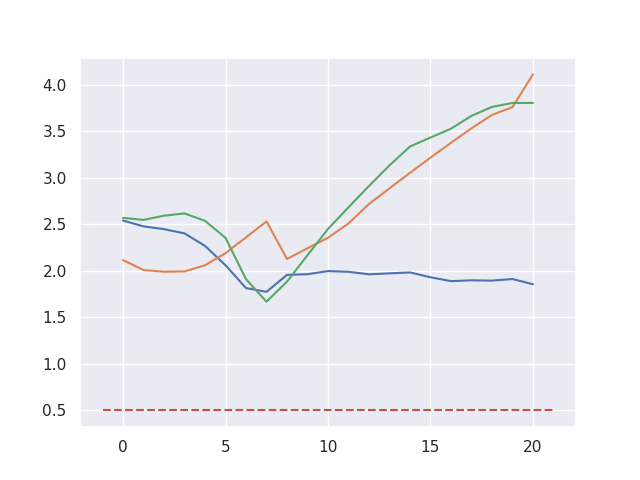

In [51]:
plt.clf()
plt.figure()
plt.plot(dec.compute_pairwise_distance(X_dec, x_dims, n_d))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

## With receding horizon:

In [95]:
%%time
#Decentralized without multiprocessing:
step_size = 2
U0 = np.zeros((N, dynamics.n_u))
N = 4
X, U, J = dec.solve_rhc(
    problem, x0, N, radius,
    centralized=False,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=0.1,
    verbose=True,
    t_kill=step_size*dt,
    t_diverge=None
)

t: 0
t: 0.1
t: 0.2
t: 0.3
t: 0.4
t: 0.5
t: 0.6
CPU times: user 1.55 s, sys: 15.6 ms, total: 1.56 s
Wall time: 1.59 s


In [96]:
print(x0.T)

[[ 0.46   1.564  1.122  0.1    0.     0.     2.294  1.634  0.966 -0.1
   0.     0.     1.378  1.469  0.947  0.     0.1    0.     0.494  0.916
   1.035  0.1    0.     0.     1.282 -0.603  1.169  0.     0.     0.
   1.784  1.444  1.007  0.     0.     0.    -1.599  1.069  0.983  0.1
   0.     0.   ]]


In [97]:
print(xf.T)

[[ 2.483  1.466  0.9    0.     0.     0.     0.52   1.378  0.949  0.
   0.     0.     1.457  2.169  1.114  0.     0.     0.    -0.466 -0.72
   1.021  0.     0.     0.     0.6    0.947  1.032  0.     0.     0.
   2.048  2.149  1.158  0.     0.     0.    -0.326  0.534  1.169  0.
   0.     0.   ]]


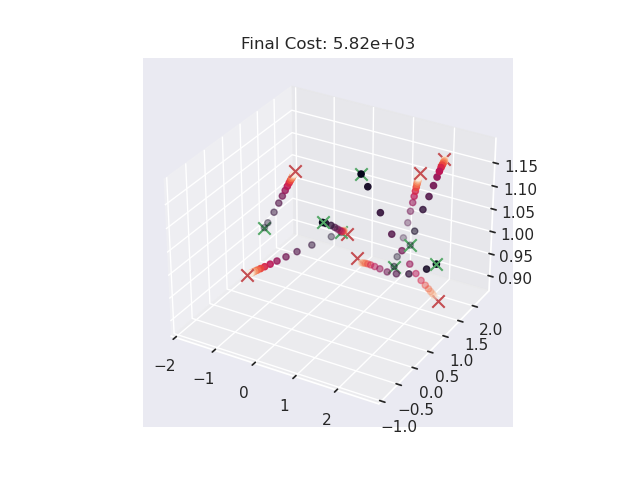

In [98]:
plt.clf()
plt.figure()
plot_solve(X, J, xf, x_dims, n_d=3)
plt.savefig('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/decentralized/media/7_drone_Trial1')

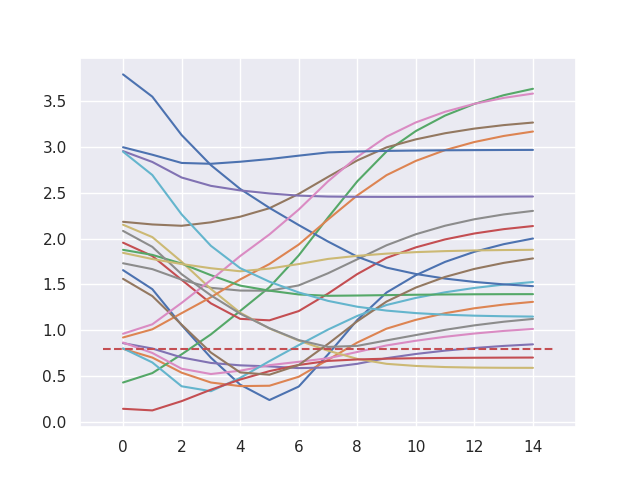

In [80]:
# plt.clf()
# plt.figure()
# plt.plot(dec.compute_pairwise_distance(X, x_dims, n_d))
# plt.hlines(radius, *plt.xlim(), 'r', ls='--')
# plt.draw()

## animation

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(5.0, 3.7))

In [ ]:
def setup(axes, X, xf, x_dims, radius):
    
    ax1, ax2 = axes
    n_agents = len(x_dims)
    handles1 = []
    for i in range(n_agents):
        handles1.append((
            ax1.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax1.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2)),
        ))
        
    for xg in split_agents(xf, x_dims):
        ax1.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, axes[0], zoom=0.15)
    plt.draw()
    
    handles2 = []
    n_pairs = pocketknives.nchoosek(n_agents, 2)
    for i in range(n_pairs):
        handles2.append(ax2.plot(0, c=plt.cm.tab20.colors[2*i])[0])
    ax2.hlines(radius, 0, X.shape[0], 'r', ls='--')
    ax2.set_ylim(0.0, distances.max())
        
    return handles1, handles2
    
def animate(t, handles1, handles2, X, x_dims, xf, distances):
    """Animate the solution into a gif"""
    
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles1):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
        
    for i, hi in enumerate(handles2):
        hi.set_xdata(range(t))
        hi.set_ydata(distances[:t, i])
    
    plt.draw()
    

In [ ]:
distances = dec.compute_pairwise_distance(X, x_dims).T
handles1, handles2 = setup(axes, X, xf.flatten(), x_dims, radius)
animate(10, handles1, handles2, X, x_dims, xf, distances)
plt.draw()

In [ ]:
handles = setup(axes, X, xf.flatten(), x_dims, radius)
anim = FuncAnimation(
    plt.gcf(), 
    animate, 
    frames=N+1, 
    fargs=(*handles, X, x_dims, xf, distances))
anim.save('traj.gif', fps=5)

## old

In [ ]:
# Old RHC for plotting...
rhc = dec.RecedingHorizonController(x0, ilqr, step_size=5)
U0 = np.zeros((ilqr.N, ilqr.n_u))
for Xi, Ui, Ji in rhc.solve(U0, J_converge=101.0, tol=tol, verbose=False):
    plt.cla()
    plot_solve(Xi, Ji, xf.T, x_dims)
    fig.canvas.draw()

In [ ]:
# Manual decentralized RHC for plotting...
step_size = 5
Xi = np.tile(x0.T, (N,1))
Ui = np.zeros((N, dynamics.n_u))
X_dec = np.zeros((0, dynamics.n_x))
U_dec = np.zeros((0, dynamics.n_u))
Ji = np.inf
J_converge = 100.0

while Ji >= J_converge:
    Xi, Ui, Ji = dec.solve_decentralized(prob, Xi, Ui, radius)
    
    X_dec = np.r_[X_dec, Xi[:step_size]]
    U_dec = np.r_[U_dec, Ui[:step_size]]
    
    # Seed the next solve by staying at the last visited state.
    Xi = np.r_[Xi[step_size:], np.tile(Xi[-1], (step_size, 1))]
    Ui = np.r_[Ui[step_size:], np.zeros((step_size, dynamics.n_u))]
    
    plt.cla()
    plot_solve(Xi[:step_size], Ji, xf.T, x_dims)
    fig.canvas.draw()